<a href="https://colab.research.google.com/github/karvesanket/financeprojects/blob/master/VaR_of_MPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing all required libraries
#Created by Sanket Karve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
from matplotlib.ticker import FuncFormatter

In [ ]:
!pip install PyPortfolioOpt
#Installing the Portfolio Optimzation Library

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier 
from pypfopt import risk_models 
from pypfopt import expected_returns
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
from matplotlib.ticker import FuncFormatter

In [ ]:
tickers = ['GOOGL','FB','AAPL','NFLX','AMZN']

thelen = len(tickers)

price_data = []
for ticker in range(thelen):
    prices = web.DataReader(tickers[ticker], start='2018-06-20', end = '2020-06-20', data_source='yahoo')
    price_data.append(prices[['Adj Close']])

df_stocks = pd.concat(price_data, axis=1)
df_stocks.columns=tickers
df_stocks.tail()


,GOOGL,FB,AAPL,NFLX,AMZN
Date,,,,,
2020-06-15,1420.739990,232.500000,342.989990,425.500000,2572.679932
2020-06-16,1446.469971,235.649994,352.079987,436.130005,2615.270020
2020-06-17,1452.540039,235.529999,351.589996,447.769989,2640.979980
2020-06-18,1434.119995,235.940002,351.730011,449.869995,2653.979980
2020-06-19,1424.640015,238.789993,349.720001,453.720001,2675.010010


In [ ]:
#Checking if any NaN values in the data
nullin_df = pd.DataFrame(df_stocks,columns=tickers)
print(nullin_df.isnull().sum())

GOOGL    0
FB       0
AAPL     0
NFLX     0
AMZN     0
dtype: int64


In [ ]:
#Annluaized Return
mu = expected_returns.mean_historical_return(df_stocks) 
#Sample Variance of Portfolio
Sigma = risk_models.sample_cov(df_stocks)

In [ ]:
#Max Sharpe Ratio - Tangent to the EF
from pypfopt import objective_functions, base_optimizer
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
sharpe_pfolio=ef.max_sharpe() #May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pwt=ef.clean_weights()
print(sharpe_pwt)


OrderedDict([('GOOGL', 0.0), ('FB', 0.0), ('AAPL', 0.92163), ('NFLX', 0.0), ('AMZN', 0.07837)])


In [ ]:
ef.portfolio_performance(verbose=True, risk_free_rate = 0.27)
# 2year risk free rate - Treasury Yield 

Expected annual return: 38.4%
Annual volatility: 35.0%
Sharpe Ratio: 0.33


(0.38375797663057254, 0.3497701562298717, 0.32523637195567334)

In [ ]:
#Min Volatility Portfolio
ef1 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
minvol=ef1.min_volatility()
minvol_pwt=ef1.clean_weights()
print(minvol_pwt)

OrderedDict([('GOOGL', 0.45111), ('FB', 0.05864), ('AAPL', 0.10749), ('NFLX', 0.04487), ('AMZN', 0.33789)])


In [ ]:
ef1.portfolio_performance(verbose=True, risk_free_rate = 0.27)

Expected annual return: 21.3%
Annual volatility: 30.0%
Sharpe Ratio: -0.19


(0.21312802566255307, 0.2995782469938058, -0.189840133281182)

In [ ]:
from pypfopt.cla import CLA
from pypfopt import discrete_allocation

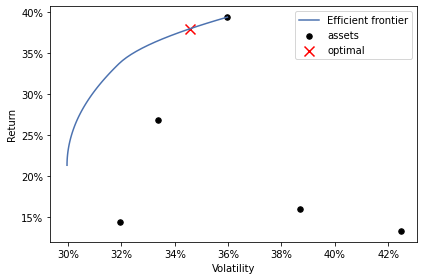

In [ ]:
cl_obj = CLA(mu, Sigma)
ax = pplt.plot_efficient_frontier(cl_obj, showfig = False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

In [ ]:
latest_prices = discrete_allocation.get_latest_prices(df_stocks)
# Allocate Portfolio Value in $ as required to show number of shares/stocks to buy, also bounds for shorting will affect allocation
#Min Volatility Portfolio Allocation $10000
allocation_minv, rem_minv = discrete_allocation.DiscreteAllocation(minvol_pwt, latest_prices, total_portfolio_value=10000).lp_portfolio() 
print(allocation_minv)
print("Leftover Fund value in$ after building minimum volatility portfolio is ${:.2f}".format(rem_minv))
print()


{'GOOGL': 3.0, 'FB': 3.0, 'AAPL': 4.0, 'NFLX': 1.0, 'AMZN': 1.0}
Leftover Fund value in$ after building minimum volatility portfolio is $482.10



In [ ]:
#Max Sharpe Ratio Portfolio Allocation $10000
latest_prices1 = discrete_allocation.get_latest_prices(df_stocks)
allocation_shp, rem_shp = discrete_allocation.DiscreteAllocation(sharpe_pwt, latest_prices1, total_portfolio_value=1000).lp_portfolio() 
print(allocation_shp)
print("Leftover Fund value in$ after building Max Sharpe ratio portfolio is ${:.2f}".format(rem_shp))

#allocation using integer programming via PyPortfolioOpt User Guide
#Alex Putkov code used for guidance and reference in applying integer programming

{'AAPL': 2.0}
Leftover Fund value in$ after building Max Sharpe ratio portfolio is $300.56


**Calculating VaR for the optimized Portfolio**

---



In [ ]:
#VaR Calculation
ticker_rx2 = []
#Convert Dictionary to list of asset weights from Max Sharpe Ratio Portfolio
sh_wt = list(sharpe_pwt.values())
sh_wt=np.array(sh_wt)

In [ ]:
for a in range(thelen):
  ticker_rx = df_stocks[[tickers[a]]].pct_change()
  ticker_rx = (ticker_rx+1).cumprod()
  ticker_rx2.append(ticker_rx[[tickers[a]]])

ticker_final = pd.concat(ticker_rx2,axis=1)
ticker_final

,GOOGL,FB,AAPL,NFLX,AMZN
Date,,,,,
2018-06-20,NaN,NaN,NaN,NaN,NaN
2018-06-21,0.987644,0.997525,0.994424,0.996833,0.988652
2018-06-22,0.987518,0.998713,0.991528,0.986395,0.980338
2018-06-25,0.962173,0.972030,0.976783,0.922545,0.950328
2018-06-26,0.956548,0.985149,0.988901,0.958321,0.966293
...,...,...,...,...,...
2020-06-15,1.199878,1.150990,1.889366,1.020971,1.470036
2020-06-16,1.221609,1.166584,1.939438,1.046478,1.494372
2020-06-17,1.226735,1.165990,1.936739,1.074407,1.509062


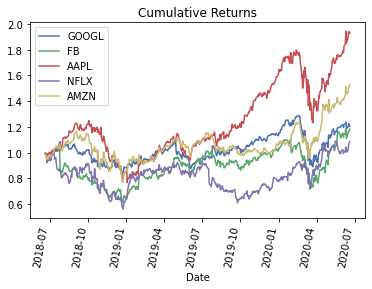

In [ ]:
#Plot graph of Cumulative/HPR of all stocks
for i, col in enumerate(ticker_final.columns):
    ticker_final[col].plot()

plt.title('Cumulative Returns')

plt.xticks(rotation=80)
plt.legend(ticker_final.columns)

#Saving the graph into a JPG file
plt.savefig('foo1.png', bbox_inches='tight')

In [ ]:
#Taking Latest Values of Return
pret = []
pre1 = []
price =[]

for x in range(thelen):
  pret.append(ticker_final.iloc[[-1],[x]])
  price.append((df_stocks.iloc[[-1],[x]]))

pre1 = pd.concat(pret,axis=1)
pre1 = np.array(pre1)
price = pd.concat(price,axis=1)
varsigma = pre1.std()

ex_rtn=pre1.dot(sh_wt)-1
price=price.dot(sh_wt) #Calculating weighted value
print(ex_rtn, varsigma,price)

[0.89525225] 0.3084696722866169 Date
2020-06-19    531.952979
dtype: float64


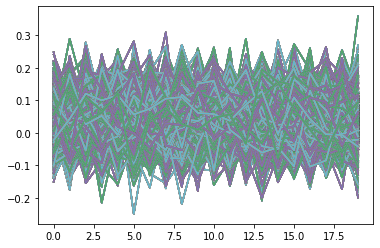

In [ ]:
from scipy.stats import norm
import math
Time=20 #No of days(steps or trading days in this case)
lt_price=[]
final_res=[]
for i in range(1000): #1000 runs of simulation 
  daily_returns=(np.random.normal(ex_rtn/Time,varsigma/math.sqrt(Time),Time)+1)-1

  lt_price=[price]

  for x in daily_returns:
    lt_price.append(lt_price[-1]*x)
    plt.plot(daily_returns)

    final_res.append(lt_price[-1])

plt.show()



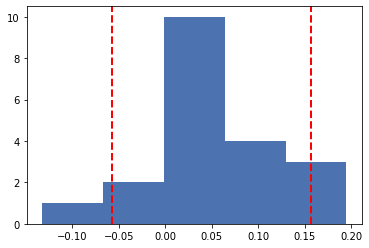

In [ ]:
plt.hist(daily_returns,bins=5)
plt.axvline(np.percentile(daily_returns,5), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(daily_returns,95), color='r', linestyle='dashed', linewidth=2)
plt.show()


In [ ]:
print(np.percentile(daily_returns,5),np.percentile(daily_returns,95)) #VaR - Minimum loss of 5.7% at a 5% probability, also a gain can be higher than 15% with a 5 % probability

-0.05740969759709193 0.15710224539992168
